In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# importing utilities
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import time

# importing models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [72]:
# results_dict = {}

# for k in range(2, 31):
for k in range(21, 31):
    results_dict[k]={}
    results_dict[k]['lr']={}
    results_dict[k]['gbr']={}
    results_dict[k]['rf']={}

In [3]:
def run_lr_n_trials(X,Y,n,k_clusters,results_dict):

    MSE_LR = np.empty([n, 1])
    MAE_LR = np.empty([n, 1])
    coefs_LR = []

    for i in range(n):
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20,random_state=i+1)
        
        # scale (mainly for better interpretation of coefs)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        try:
            lr = LinearRegression().fit(X_train_scaled, Y_train)
        except:
            pdb.set_trace()
            
        mse = mean_squared_error(Y_test,lr.predict(X_test_scaled))
        mae = mean_absolute_error(Y_test,lr.predict(X_test_scaled))
        MSE_LR[i] = mse
        MAE_LR[i] = mae

        feature_coefs = pd.DataFrame(zip(X_train.columns.tolist(), lr.coef_.tolist()),columns=['feature','coef'])
        coefs_LR.append(feature_coefs)
    
    results_dict[k_clusters]['lr']['mse_list'] = MSE_LR
    results_dict[k_clusters]['lr']['mae_list'] = MAE_LR
    results_dict[k_clusters]['lr']['coef_df_list'] = coefs_LR

In [38]:
# Creating random grid for GBR

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 20)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 20)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(5, 105, num = 11)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(5, 105, num = 11)]

# Create the random grid
random_grid_gb = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }


def run_gbr_n_trials(X,Y,n,k_clusters,results_dict,random_grid_gb):
    
    MSE_GBR = np.empty([n, 1])
    MAE_GBR = np.empty([n, 1])
    best_params_GBR = []
    
    for i in range(n):
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20,random_state=i+1)
        
        gb = GradientBoostingRegressor()
        gb_random = BayesSearchCV(estimator = gb,search_spaces = random_grid_gb, n_iter = 20, cv = 3, verbose=2, random_state=1, n_jobs = -1)
        gb_random.fit(X_train, Y_train)
        
        gbr = GradientBoostingRegressor(**gb_random.best_params_).fit(X_train, Y_train)
        mse = mean_squared_error(Y_test,gbr.predict(X_test))
        mae = mean_absolute_error(Y_test,gbr.predict(X_test))
        
        MSE_GBR[i] = mse
        MAE_GBR[i] = mae
        best_params_GBR.append(gb_random.best_params_)
        
        print("{i}-th loop of gb tuning complete".format(i=i))
    
    results_dict[k_clusters]['gbr']['mse_list'] = MSE_GBR
    results_dict[k_clusters]['gbr']['mae_list'] = MAE_GBR
    results_dict[k_clusters]['gbr']['coef_df_list'] = best_params_GBR

In [37]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 20)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 20)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(5, 105, num = 11)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(5, 105, num = 11)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

def run_rf_n_trials(X,Y,n,k_clusters,results_dict,random_grid_rf):
    
    MSE_RF = np.empty([n, 1])
    MAE_RF = np.empty([n, 1])
    best_params_RF = []
    
    for i in range(n):
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20,random_state=i+1)
        
        rf = RandomForestRegressor()
        rf_random = BayesSearchCV(estimator = rf,search_spaces = random_grid_rf, n_iter = 20, cv = 3, verbose=2, random_state=1, n_jobs = -1)
        rf_random.fit(X_train, Y_train)
        
        rf = RandomForestRegressor(**rf_random.best_params_).fit(X_train, Y_train)
        mse = mean_squared_error(Y_test,rf.predict(X_test))
        mae = mean_absolute_error(Y_test,rf.predict(X_test))
        
        MSE_RF[i] = mse
        MAE_RF[i] = mae
        best_params_RF.append(rf_random.best_params_)
        
        print("{i}-th loop of rf tuning complete".format(i=i))
    
    results_dict[k_clusters]['rf']['mse_list'] = MSE_RF
    results_dict[k_clusters]['rf']['mae_list'] = MAE_RF
    results_dict[k_clusters]['rf']['coef_df_list'] = best_params_RF

In [83]:
# for k in range(2, 31):
for k in range(30, 31):
    monthly_win_rates_w_clusters = pd.read_csv('monthly_win_rates - {k} cluster data.csv'.format(k=k),index_col=0)
    
    min_5_games_filter = monthly_win_rates_w_clusters['L']+monthly_win_rates_w_clusters['W'] > 5
    data = monthly_win_rates_w_clusters[min_5_games_filter].pivot_table(index=['GAME_MONTH','TEAM_NAME','win_%','cumulative_win_%','opp_avg_cumulative_win_%'],columns='cluster',values='MIN_%').reset_index().iloc[:,2:]
    data = data.rename_axis(None, axis=1)
    
    X = data.iloc[:,2:]
    Y = data['win_%']
    
    lr_start_time = time.time()
    run_lr_n_trials(X,Y,20,k,results_dict)
    lr_end_time = time.time()
    print("Time elapsed for {k} clusters LR: ".format(k=k), lr_end_time -lr_start_time)
    
    gbr_start_time = time.time()
    run_gbr_n_trials(X,Y,20,k,results_dict,random_grid_gb)
    gbr_end_time = time.time()
    print("Time elapsed for {k} clusters GBR: ".format(k=k), gbr_end_time - gbr_start_time)
    
    rf_start_time = time.time()
    run_rf_n_trials(X,Y,20,k,results_dict,random_grid_rf)
    rf_end_time = time.time()
    print("Time elapsed for {k} clusters RF: ".format(k=k), rf_end_time - rf_start_time)


Time elapsed for 30 clusters LR:  0.1718747615814209
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fit

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
6-th loop of gb tuning complete
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
13-th loop of gb tuning complete
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for eac

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
0-th loop of rf tuning complete
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
7-th loop of rf tuning complete
Fitting 3 folds for each

13-th loop of rf tuning complete
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for eac

In [88]:
baseline_prediction = data['cumulative_win_%']

baseline_mse = mean_squared_error(Y,baseline_prediction)
baseline_mae = mean_absolute_error(Y,baseline_prediction)

print("Baseline Mean Squared Error: ", baseline_mse)
print("Baseline Mean Absolute Error: ", baseline_mae)

Baseline Mean Squared Error:  0.04471018138384986
Baseline Mean Absolute Error:  0.16074024299039724


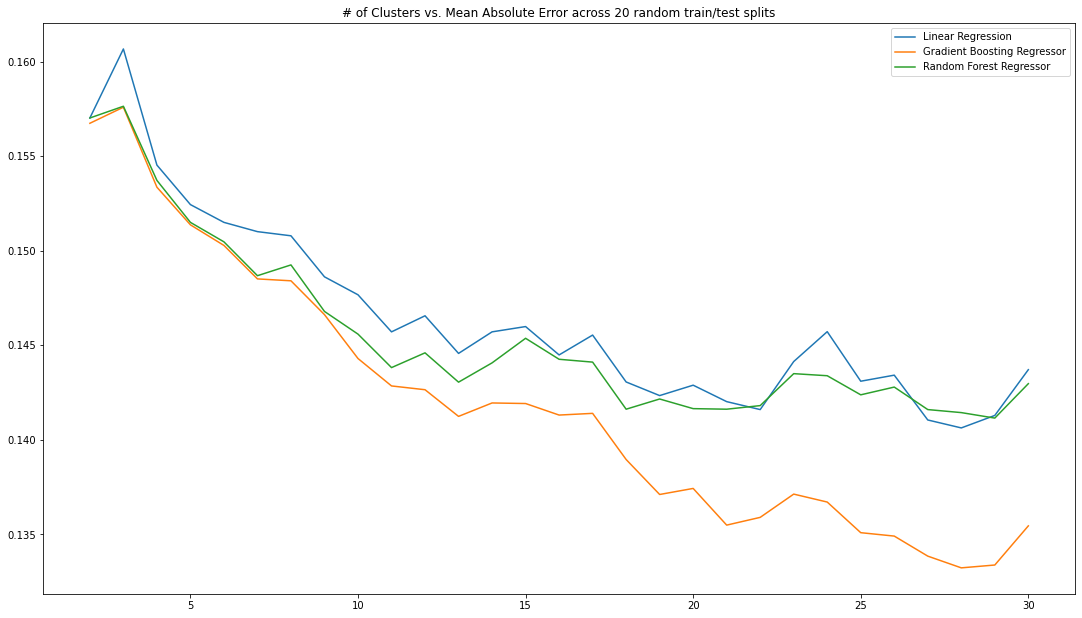

In [86]:
fig, ax1 = plt.subplots(1, 1)

fig.set_size_inches(18.5, 10.5)

ax1.set_title("# of Clusters vs. Mean Absolute Error across 20 random train/test splits")

ax1.plot(np.arange(2, 31),[np.round(np.mean(results_dict[k]['lr']['mae_list']),5) for k in np.arange(2, 31)],label='Linear Regression')
ax1.plot(np.arange(2, 31),[np.round(np.mean(results_dict[k]['gbr']['mae_list']),5) for k in np.arange(2, 31)],label='Gradient Boosting Regressor')
ax1.plot(np.arange(2, 31),[np.round(np.mean(results_dict[k]['rf']['mae_list']),5) for k in np.arange(2, 31)],label='Random Forest Regressor')

# add in baseline

ax1.legend()

plt.show()

In [85]:
for k in range(2,31):
    print('{k} clusters:'.format(k=k))
    print("linear regression params:")
    print(results_dict[k]['lr']['coef_df_list'])
    print("gbr params:")
    print(results_dict[k]['gbr']['coef_df_list'])
    print("rf params:")
    print(results_dict[k]['rf']['coef_df_list'])
    print("------------------------")

2 clusters:
linear regression params:
[                    feature          coef
0  opp_avg_cumulative_win_% -3.223105e-02
1                       0.0  3.675913e+12
2                       1.0  3.675913e+12,                     feature          coef
0  opp_avg_cumulative_win_% -2.989454e-02
1                       0.0 -1.077619e+13
2                       1.0 -1.077619e+13,                     feature          coef
0  opp_avg_cumulative_win_% -3.136999e-02
1                       0.0  7.212182e+12
2                       1.0  7.212182e+12,                     feature          coef
0  opp_avg_cumulative_win_% -2.529012e-02
1                       0.0 -3.942822e+12
2                       1.0 -3.942822e+12,                     feature          coef
0  opp_avg_cumulative_win_% -2.386034e-02
1                       0.0 -1.204822e+13
2                       1.0 -1.204822e+13,                     feature          coef
0  opp_avg_cumulative_win_% -2.896978e-02
1                       0.0  1.7

[                     feature          coef
0   opp_avg_cumulative_win_% -2.913146e-02
1                        0.0  2.031496e+12
2                        1.0  2.358819e+12
3                        2.0  1.827846e+12
4                        3.0  1.856854e+12
5                        4.0  2.303918e+12
6                        5.0  2.796137e+12
7                        6.0  2.804714e+12
8                        7.0  1.444273e+12
9                        8.0  4.939918e+11
10                       9.0  1.625394e+11
11                      10.0  2.135242e+12,                      feature          coef
0   opp_avg_cumulative_win_% -2.678401e-02
1                        0.0 -1.341618e+12
2                        1.0 -1.529209e+12
3                        2.0 -1.203741e+12
4                        3.0 -1.217005e+12
5                        4.0 -1.510568e+12
6                        5.0 -1.826239e+12
7                        6.0 -1.864962e+12
8                        7.0 -9.303794e+11
9        

[                     feature          coef
0   opp_avg_cumulative_win_% -3.135204e-02
1                        0.0  3.276745e+12
2                        1.0  4.150451e+12
3                        2.0  5.176897e+12
4                        3.0  2.166437e+12
5                        4.0  4.493262e+12
6                        5.0  3.501089e+12
7                        6.0  4.077346e+11
8                        7.0  4.997731e+12
9                        8.0  5.754150e+12
10                       9.0  2.938675e+12
11                      10.0  3.251964e+12
12                      11.0  3.555824e+11
13                      12.0  4.326438e+12
14                      13.0  3.935820e+12
15                      14.0  5.926369e+12
16                      15.0  2.518938e+09
17                      16.0  3.459097e+12
18                      17.0  1.450530e+12,                      feature          coef
0   opp_avg_cumulative_win_% -2.847382e-02
1                        0.0  1.667499e+12
2        

[                     feature          coef
0   opp_avg_cumulative_win_% -3.093998e-02
1                        0.0  1.020418e+10
2                        1.0  9.873283e+09
3                        2.0  1.674257e+10
4                        3.0  4.058870e+09
5                        4.0  1.723318e+10
6                        5.0  5.730033e+09
7                        6.0  8.127702e+08
8                        7.0  1.402052e+10
9                        8.0  1.523037e+10
10                       9.0  9.273717e+09
11                      10.0  1.167358e+10
12                      11.0  1.386248e+10
13                      12.0  9.102185e+09
14                      13.0  6.896981e+08
15                      14.0  1.605405e+10
16                      15.0  8.676180e+06
17                      16.0  1.188635e+10
18                      17.0  2.671826e+09
19                      18.0  1.088731e+10
20                      19.0  8.367960e+09
21                      20.0  1.117686e+10
22        